<a href="https://colab.research.google.com/github/TianB33/COMP551Miniprojects/blob/main/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP 551 Assignment 2

## Task 1: Acquire the data

In [ ]:
import torch as t
import torchvision as tv
import numpy as np
import matplotlib.pyplot as plt
import warnings
import math

# to suppress warnings
warnings.filterwarnings("ignore")

dir = "./data"

### Dataset 1: Fashion MNIST

100%|██████████| 26421880/26421880 [00:01<00:00, 18687427.45it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 299787.58it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5484824.06it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21127472.59it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

60000
10000
Ankle boot T-shirt/top T-shirt/top Dress T-shirt/top Pullover Sneaker Pullover


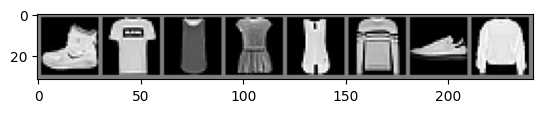

In [ ]:
# Don't forget to include normalization
mnist_transform = tv.transforms.Compose([tv.transforms.ToTensor(), tv.transforms.Normalize((0.5), (0.5))])

mnist_train_df = tv.datasets.FashionMNIST(root=dir, train=True, transform=mnist_transform, download=True)
mnist_test_df = tv.datasets.FashionMNIST(root=dir, train=False, transform=mnist_transform, download=True)

# see the size of data
print(len(mnist_train_df))
print(len(mnist_test_df))
# trainset: 60000, testset: 10000

# hardcode the classes of MNIST dataset
mnist_class = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

# extract some sample from the dataset and see the pictures
mnist_sample = 8
mnist_sample_loader = t.utils.data.DataLoader(mnist_train_df, batch_size=mnist_sample, shuffle=False)

# for convenience, write a show picture function (for grayscale pictures)
def show_grey_img(img, denormalize=True):
    if denormalize:
        img = img / 2 + 0.5
    npimg = img.numpy()
    # adjust the shape (permute the axis) to show image
    npimg = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg, cmap='gray')

mnist_imgiter = iter(mnist_sample_loader)
mnist_img, mnist_lbl = next(mnist_imgiter)
show_grey_img(tv.utils.make_grid(mnist_img))
print(' '.join(f'{mnist_class[mnist_lbl[i]]}' for i in range(mnist_sample)))
# note that FashionMNIST images are (channel 1x) 28 x 28

### Dataset 2: CIFAR-10

100%|██████████| 170498071/170498071 [00:02<00:00, 72070846.60it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
50000
10000


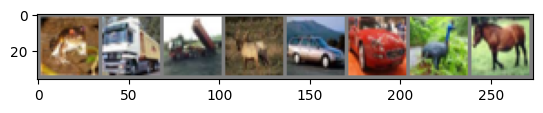

frog truck truck deer car car bird horse


In [ ]:
# Don't forget to include normalization
cifar_transform = tv.transforms.Compose([tv.transforms.ToTensor(), tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

cifar_train_df = tv.datasets.CIFAR10(root=dir, train=True, transform=cifar_transform, download=True)
cifar_test_df = tv.datasets.CIFAR10(root=dir, train=False, transform=cifar_transform, download=True)

# see the size of data
print(len(cifar_train_df))
print(len(cifar_test_df))
# trainset: 50000, testset: 10000

# hardcode the classes of CIFAR dataset
cifar_class = ('plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck')

# extract some sample from the dataset and see the pictures
cifar_sample = 8
cifar_sample_loader = t.utils.data.DataLoader(cifar_train_df, batch_size=cifar_sample, shuffle=False)

# for convenience, write a show picture function (for rgb pictures)
def show_img(img, denormalize=True):
    if denormalize:
        img = img / 2 + 0.5
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg)
    plt.show()

cifar_imgiter = iter(cifar_sample_loader)
cifar_img, cifar_lbl = next(cifar_imgiter)
show_img(tv.utils.make_grid(cifar_img))
print(' '.join(f'{cifar_class[cifar_lbl[i]]}' for i in range(cifar_sample)))
# note that CIFAR images are (channel 3x) 32 x 32

## Task 2: Implement a Multilayer Perceptron (MLP)

In [ ]:
class MLP:
    # both our dataset has 10 classes, so by default C = 10
    def __init__(self, ac, ac_derivative, C=10, hidden=2, units=[128, 128], initializer="kaiming", regularization=0, regularization_coeff=0.001):
        assert len(units) == hidden
        self.ac = ac
        self.ac_derivative = ac_derivative
        self.C = C
        self.hidden = hidden
        self.units = units
        self.initializer = initializer
        self.regularization = regularization
        self.regularization_coeff = regularization_coeff
        np.random.seed(33)

    def param_init(self, X):
        N, D = X.shape
        # in our implementation of MLP, we treat weights and biases seperately (instead of attaching a new column to every matrix)
        self.weights = []
        self.biases = []
        if self.initializer == "zero":
            for i in range(self.hidden + 1):
                # get the row and column number for each matrix
                row = D if i == 0 else self.units[i-1]
                column = self.C if i == self.hidden else self.units[i]
                self.weights.append(np.zeros((row, column)))
                self.biases.append(np.zeros(column))
        if self.initializer == "uniform":
            for i in range(self.hidden + 1):
                row = D if i == 0 else self.units[i-1]
                column = self.C if i == self.hidden else self.units[i]
                self.weights.append(np.random.uniform(-1, 1, (row, column)))
                self.biases.append(np.random.uniform(-1, 1, column))
        if self.initializer == "gaussian":
            for i in range(self.hidden + 1):
                row = D if i == 0 else self.units[i-1]
                column = self.C if i == self.hidden else self.units[i]
                self.weights.append(np.random.randn(row, column))
                self.biases.append(np.random.randn(column))
        if self.initializer == "xavier":
            for i in range(self.hidden + 1):
                row = D if i == 0 else self.units[i-1]
                column = self.C if i == self.hidden else self.units[i]
                # note that xavier initialization: Unif[-1/sqrt(n), 1/sqrt(n)] where n = inputsize
                hi = 1 / np.sqrt(row)
                self.weights.append(np.random.uniform(-hi, hi, (row, column)))
                self.biases.append(np.random.uniform(-hi, hi, column))
        if self.initializer == "normalized xavier":
            for i in range(self.hidden + 1):
                row = D if i == 0 else self.units[i-1]
                column = self.C if i == self.hidden else self.units[i]
                # note that normalized xavier initialization: Unif[-sqrt(6/n+m), sqrt(6/n+m)] where n = inputsize, m = outputsize
                hi = np.sqrt(6 / (row + column))
                self.weights.append(np.random.uniform(-hi, hi, (row, column)))
                self.biases.append(np.random.uniform(-hi, hi, column))
        if self.initializer == "kaiming":
            for i in range(self.hidden + 1):
                row = D if i == 0 else self.units[i-1]
                column = self.C if i == self.hidden else self.units[i]
                # note that kaiming initialization: N(0, 2/n) where n = inputsize
                variance = 2 / row
                self.weights.append(np.random.randn(row, column) * np.sqrt(variance))
                self.biases.append(np.zeros(column))

    # need to apply softmax for last layer's activation
    def softmax(self, a):
        # to avoid overflow:
        e = np.exp(a - np.max(a))
        return e / np.sum(e, axis=1, keepdims=True)

    def calculate_loss(self, predictions, y):
        # expect predictions to be 1d (not probabilities)
        assert len(y) == len(predictions)
        if y.ndim == 1:
            y = np.eye(self.C)[y]
        N, C = y.shape
        return -1 * np.sum(y * np.log(predictions)) / N

    def calculate_accuracy(self, predictions, y):
        # expect predictions to be 1d, y to be 1d
        assert len(y) == len(predictions)
        correct = np.count_nonzero(y == predictions)
        accuracy = correct / len(y)
        return accuracy

    def calculate_metric_given_X(self, X, y):
        # expect X to be N x D, y to be N x 1 (real data and labels)
        raw = self.predict(X, raw=True)
        predictions = np.argmax(raw, axis=1)
        loss = self.calculate_loss(raw, y)
        accuracy = self.calculate_accuracy(predictions, y)
        return loss, accuracy

    def forward(self, X):
                              # X: N x Features[0] (= 28 x 28 x 1 or 32 x 32 x 3)
        activations = [X]     # after applying activations
        z_values = []         # z-values: z = Xw (before applying activations)

        for i in range(len(self.weights)):                              # using i = 0:
            z = activations[-1] @ self.weights[i] + self.biases[i]      # weights[0]: Features[0] x Features[1] (= units[0])
                                                                        # biases[0]: 1 x Features[1] (add for each row)
            X = self.ac(z)                                              # X for next pass: N x Features[1]
            activations.append(X)
            z_values.append(z)
        return activations, z_values

    # Note that in our model, we also apply activation on the last layer's z, which is different that that in the slides.
    # That is, our yhat = softmax(f(z)) where f is the activation; in the slides it's yhat = softmax(z).

    def backward(self, X, y, lr, activations, z_values, forwarded=False):
        # add new parameter activations, z-value and forwarded, to avoid reduntantly running it inside fit function.
        N, D = X.shape
        if not forwarded:
            activations, z_values = self.forward(X)          # activation[-1]: N x C
        y_hat = self.softmax(activations[-1])            # yhat: N x C

        # simplified dL/da
        dL_da = y_hat - y                                # N x C
        dL_dz = dL_da * self.ac_derivative(z_values[-1]) # N x C

        deltas = [dL_dz]
        for i in range(self.hidden - 1, -1, -1):
            delta = (deltas[-1] @ self.weights[i+1].T) * self.ac_derivative(z_values[i])
            # print(delta)
                                                         # using i = self.hidden - 1:
                                                         # deltas[-1] = dL/dz: N x C
                                                         # self.weights[self.hidden] = units[-1] x C
                                                         # deltas[-1] * self.weights[i+1].T = dL/da_prev: N x units[-1]
            deltas.append(delta)
        # reverse deltas for convenience
        deltas = deltas[::-1]
        for i in range(self.hidden + 1):
            if self.regularization == 0:
                self.weights[i] -= lr * (activations[i].T @ deltas[i]) / N
                                                         # using i = self.hidden:
                                                         # length of activations is 2 + self.hidden, length of deltas is 1 + self.hidden
                                                         # activations[self.hidden]: N x units[-1]
                                                         # deltas[self.hidden]: N x C
                                                         # activation[i].T @ deltas[i]: units[-1] x C == weights[self.hidden]
                self.biases[i] -= lr * np.sum(deltas[i], axis=0) / N
            if self.regularization == 1:
                # similar, but with regularization loss' update
                self.weights[i] -= lr * ((activations[i].T @ deltas[i]) / N + self.regularization_coeff * np.sign(self.weights[i]))
                self.biases[i] -= lr * (np.sum(deltas[i], axis=0) / N + self.regularization_coeff * np.sign(self.biases[i]))
            if self.regularization == 2:
                self.weights[i] -= lr * ((activations[i].T @ deltas[i]) / N + 2 * self.regularization_coeff * self.weights[i])
                self.biases[i] -= lr * (np.sum(deltas[i], axis=0) / N + 2 * self.regularization_coeff * self.biases[i])

    def fit(self, X, y, lr=0.01, batchsize=256, epochs=1000):
        # expected parameters:
        # X: N x D matrix, y: N x 1 vector
        self.param_init(X)

        y_one_hot = np.eye(self.C)[y]               # one-hot encode y
        N, D = X.shape
        # record the loss and accuracy per step
        loss_per_step = []
        regularization_loss_per_step = []
        accuracy_per_step = []

        # Apply SGD:
        for epoch in range(epochs):
            # randomly permute the data
            indices = np.random.permutation(N)
            X_shuffled = X[indices]
            y_shuffled = y[indices]
            y_one_hot_shuffled = y_one_hot[indices]

            for i in range(0, N, batchsize):
                # get the batch for this iteration
                X_batch = X_shuffled[i:i+batchsize]
                y_batch = y_shuffled[i:i+batchsize]
                y_one_hot_batch = y_one_hot_shuffled[i:i+batchsize]

                activations, z_values = self.forward(X_batch)
                probabilities = self.softmax(activations[-1])
                predictions = np.argmax(probabilities, axis=1)

                # calculate regularization loss
                regularization_loss = 0
                if self.regularization == 1:
                    for _, matrix in enumerate(self.weights):
                        regularization_loss += np.sum(np.absolute(matrix))
                    for _, vector in enumerate(self.biases):
                        regularization_loss += np.sum(np.absolute(vector))
                if self.regularization == 2:
                    for _, matrix in enumerate(self.weights):
                        regularization_loss += np.linalg.norm(matrix, ord='fro') ** 2
                    for _, vector in enumerate(self.biases):
                        regularization_loss += np.linalg.norm(vector) ** 2

                regularization_loss_per_step.append(regularization_loss * self.regularization_coeff / N)
                loss_per_step.append(self.calculate_loss(probabilities, y_batch))
                accuracy_per_step.append(self.calculate_accuracy(predictions, y_batch))
                # note that the update step is not dependent on the regularization loss value
                self.backward(X_batch, y_one_hot_batch, lr, activations, z_values, True)

        return loss_per_step, regularization_loss_per_step, accuracy_per_step

    def predict(self, X, raw=False):
        activations, _ = self.forward(X)
        predictions = self.softmax(activations[-1])
        if raw:
            return predictions
        y_pred = np.argmax(predictions, axis=1)
        return y_pred

## Task 3: Run the experiments and report

### Subtask 3.1: Test the model's performance under different initializations

In [ ]:
# define ReLU function and its derivative, so we can pass it to our MLP class
def ReLU(x):
    return np.maximum(x, 0)

def ReLU_derivative(x):
    return np.where(x >= 0, 1, 0)

In [ ]:
# load our data in MNIST. Due to colab's speed (we didn't use the cloud credits), we use a smaller size here.
mnist_train_size = 1024
mnist_train_loader = t.utils.data.DataLoader(mnist_train_df, batch_size=mnist_train_size, shuffle=True)
mnist_train_iter = iter(mnist_train_loader)
mnist_X_tensor, mnist_y_tensor = next(mnist_train_iter)

# Collapse the 1, 2, 3 dimensions of X_tensor into 1
mnist_X = mnist_X_tensor.numpy().reshape((mnist_train_size, -1))
mnist_y = mnist_y_tensor.numpy()

mnist_test_size = 10000
mnist_test_loader = t.utils.data.DataLoader(mnist_test_df, batch_size=mnist_test_size, shuffle=False)
mnist_test_iter = iter(mnist_test_loader)
mnist_X_test_tensor, mnist_y_test_tensor = next(mnist_test_iter)

mnist_X_test = mnist_X_test_tensor.numpy().reshape((mnist_test_size, -1))
mnist_y_test = mnist_y_test_tensor.numpy()

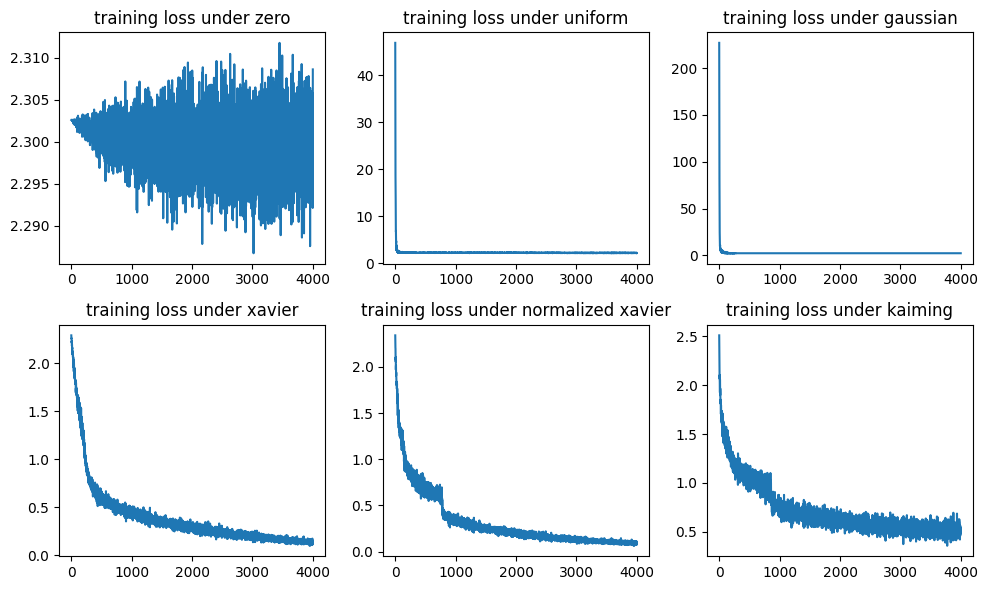

[0.1, 0.1252, 0.1009, 0.7999, 0.7977, 0.6315]


In [ ]:
# Now, we can test the performance of different initializers:

initializers = ["zero", "uniform", "gaussian", "xavier", "normalized xavier", "kaiming"]
losses = []          # train
accuracies = []      # test
for i in range(6):
    init = initializers[i]
    model = MLP(ReLU, ReLU_derivative, hidden=1, units=[128], initializer=init)
    loss, _, _ = model.fit(mnist_X, mnist_y, epochs=1000)
    losses.append(loss)
    _, accuracy = model.calculate_metric_given_X(mnist_X_test, mnist_y_test)
    accuracies.append(accuracy)

plt.figure(figsize=(10, 6))
for i in range(6):
    p = plt.subplot(2, 3, i+1)
    p.plot(losses[i])
    p.set_title("training loss under {0}".format(initializers[i]))
plt.tight_layout()
plt.show()

print(accuracies)

# (note that the scale of the graphs are different)
# In general, zero initialization is the worst since one cannot even train a MLP using it. For every step, the weights is never updated.
# the loss is oscillating because biase get updated (but not necessarily toward the gradient's direction).
# uniform and gaussian works, but we can see that the loss when they stablize is larger than that of xavier's and kaiming's.
# It turns out that normalized xavier has the best performance (in terms of training loss; it might overfit).

### Subtask 3.2: Test the model's performance under different depth

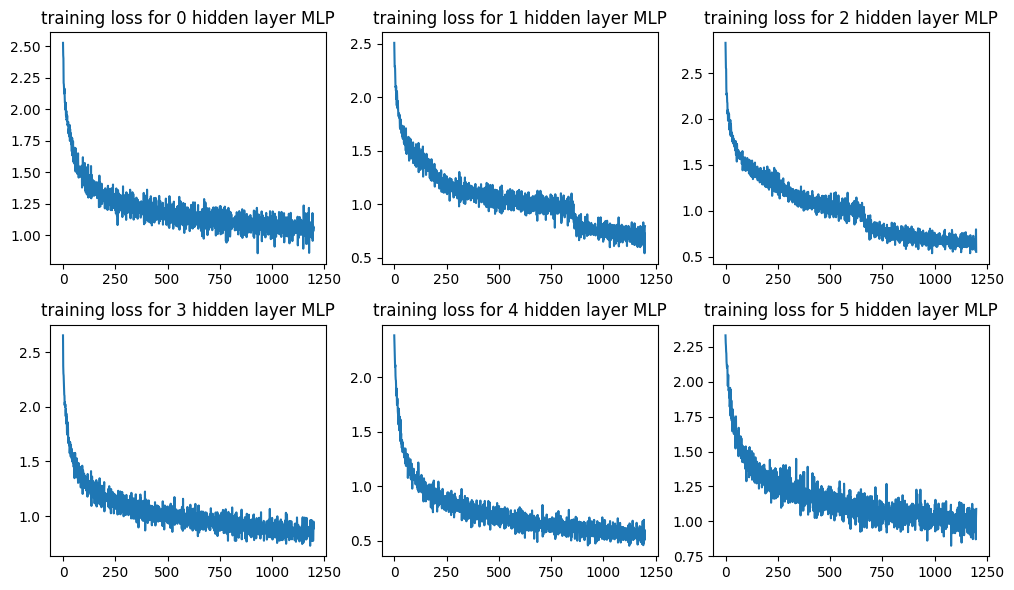

[0.57, 0.6194, 0.6129, 0.6269, 0.7037, 0.5847]


In [ ]:
losses = []
accuracies = []

for i in range(6):
    model = MLP(ReLU, ReLU_derivative, hidden=i, units=[128] * i, initializer="kaiming")
    loss, _, _ = model.fit(mnist_X, mnist_y, epochs=300)
    losses.append(loss)
    _, accuracy = model.calculate_metric_given_X(mnist_X_test, mnist_y_test)
    accuracies.append(accuracy)

plt.figure(figsize=(10, 6))
for i in range(6):
    p = plt.subplot(2, 3, i+1)
    p.plot(losses[i])
    p.set_title("training loss for {} hidden layer MLP".format(i))
plt.tight_layout()
plt.show()

print(accuracies)

### Subtask 3.3: Test the performance of model with different activations

In [ ]:
# we will test some other activations:
def logistic(x):
    return 1 / (np.exp(-x) + 1)

def logistic_derivative(x):
    tmp = np.exp(-x)
    return tmp / (1 + tmp) ** 2

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - tanh(x) ** 2

def leaky_ReLU(x):  # gamma = 0.01
    return np.maximum(x, 0) + np.minimum(0, x) * 0.01

def leaky_ReLU_derivative(x):
    return np.where(x >= 0, 1, 0.01)

def softplus(x):
    return np.log1p(np.exp(x))

def softplus_derivative(x):
    tmp = np.exp(x)
    return tmp / (1 + tmp)

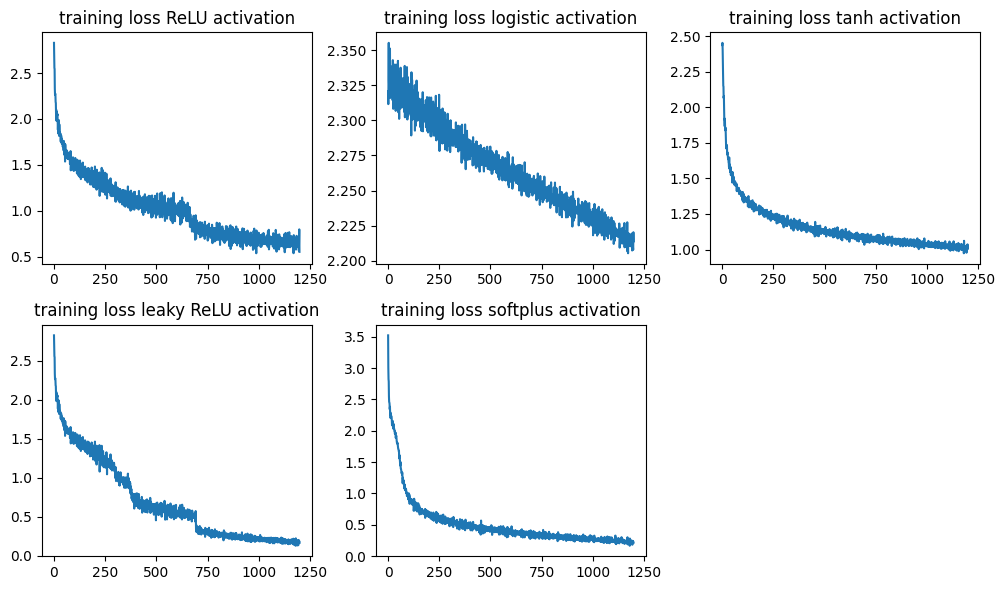

[0.6129, 0.2463, 0.7768, 0.7868, 0.7914]


In [ ]:
activations = [ReLU, logistic, tanh, leaky_ReLU, softplus]
activation_derivatives = [ReLU_derivative, logistic_derivative, tanh_derivative, leaky_ReLU_derivative, softplus_derivative]
names = ["ReLU", "logistic", "tanh", "leaky ReLU", "softplus"]
losses = []
accuracies = []

for i in range(5):
    model = MLP(activations[i], activation_derivatives[i], hidden=2, units=[128,128], initializer="kaiming")
    loss, _, _ = model.fit(mnist_X, mnist_y, epochs=300)
    losses.append(loss)
    _, accuracy = model.calculate_metric_given_X(mnist_X_test, mnist_y_test)
    accuracies.append(accuracy)

plt.figure(figsize=(10, 6))
for i in range(5):
    p = plt.subplot(2, 3, i+1)
    p.plot(losses[i])
    p.set_title("training loss {} activation".format(names[i]))
plt.tight_layout()
plt.show()

print(accuracies)

# reasons why logistic activation performs significantly worse compared to others (esp. tanh):
# non-zero mean (tanh don't suffer from this!) -> small difference since value is far from zero -> small gradient -> bad updates
# we could also see tanh, leakyReLu and softplus works well

### Subtask 3.4: Test the model's performance after adding regularization (L1, L2)

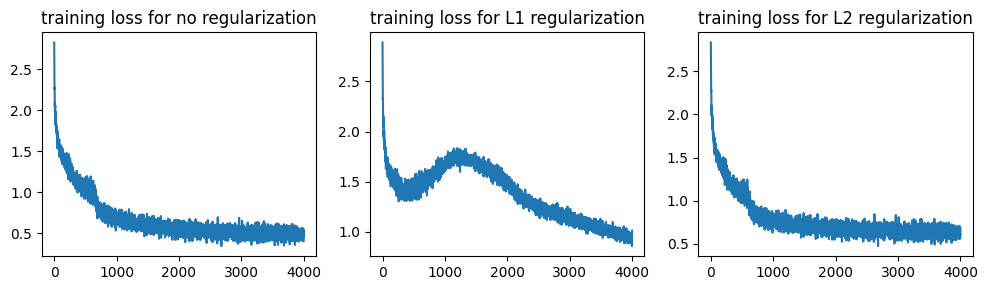

[0.6174, 0.6574, 0.6207]


In [ ]:
regularizations = [0, 1, 2]
losses = []
regu_losses = []
accuracies = []
names = ["no regularization", "L1 regularization", "L2 regularization"]

for i in range(3):
    model = MLP(ReLU, ReLU_derivative, regularization=i, regularization_coeff=0.01)
    loss, regu_loss, _ = model.fit(mnist_X, mnist_y, epochs=1000)
    losses.append(loss)
    regu_losses.append(regu_loss)
    _, accuracy = model.calculate_metric_given_X(mnist_X_test, mnist_y_test)
    accuracies.append(accuracy)

plt.figure(figsize=(10, 3))
for i in range(3):
    p = plt.subplot(1, 3, i+1)
    p.plot(np.add(losses[i], regu_losses[i]))
    p.set_title("training loss for {}".format(names[i]))
plt.tight_layout()
plt.show()

print(accuracies)

### Subtask 3.5: Test the model's performance if the input is not normalized

In [ ]:
# note the difference: this time we don't use Normalize()
mnist_transform_nonorm = tv.transforms.Compose([tv.transforms.ToTensor()])
# mnist_transform_nonorm = tv.transforms.Compose([tv.transforms.ToTensor(), tv.transforms.Normalize((0.5), (0.5))])

mnist_train_df_nonorm = tv.datasets.FashionMNIST(root=dir, train=True, transform=mnist_transform_nonorm, download=True)
mnist_test_df_nonorm = tv.datasets.FashionMNIST(root=dir, train=False, transform=mnist_transform_nonorm, download=True)

mnist_train_size_nonorm = 1024
mnist_train_loader_nonorm = t.utils.data.DataLoader(mnist_train_df_nonorm, batch_size=mnist_train_size_nonorm, shuffle=True)
mnist_train_iter_nonorm = iter(mnist_train_loader_nonorm)
mnist_X_tensor_nonorm, mnist_y_tensor_nonorm = next(mnist_train_iter_nonorm)

# Collapse the 1, 2, 3 dimensions of X_tensor into 1
mnist_X_nonorm = mnist_X_tensor_nonorm.numpy().reshape((mnist_train_size_nonorm, -1))
mnist_y_nonorm = mnist_y_tensor_nonorm.numpy()

mnist_test_size_nonorm = 10000
mnist_test_loader_nonorm = t.utils.data.DataLoader(mnist_test_df_nonorm, batch_size=mnist_test_size_nonorm, shuffle=False)
mnist_test_iter_nonorm = iter(mnist_test_loader_nonorm)
mnist_X_test_tensor_nonorm, mnist_y_test_tensor_nonorm = next(mnist_test_iter_nonorm)

mnist_X_test_nonorm = mnist_X_test_tensor_nonorm.numpy().reshape((mnist_test_size_nonorm, -1))
mnist_y_test_nonorm = mnist_y_test_tensor_nonorm.numpy()

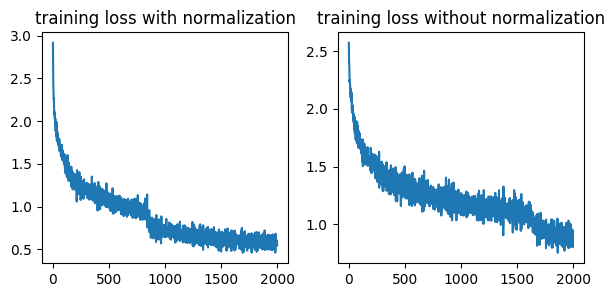

0.6536
0.6272


In [ ]:
# previous model, with normalization:
model = MLP(ReLU, ReLU_derivative)
loss, _, _ = model.fit(mnist_X, mnist_y, epochs=500)
_, accuracy = model.calculate_metric_given_X(mnist_X_test, mnist_y_test)

# without normalization
model_nonorm = MLP(ReLU, ReLU_derivative)
loss_nonorm, _, _ = model_nonorm.fit(mnist_X_nonorm, mnist_y_nonorm, epochs=500)
_, accuracy_nonorm = model_nonorm.calculate_metric_given_X(mnist_X_test_nonorm, mnist_y_test_nonorm)

plt.figure(figsize=(7, 3))
p = plt.subplot(1, 2, 1)
p.plot(loss)
p.set_title("training loss with normalization")
q = plt.subplot(1, 2, 2)
q.plot(loss_nonorm)
q.set_title("training loss without normalization")
plt.show()

print(accuracy)
print(accuracy_nonorm)

# one can see that with normalization, our SGD converge faster, and we have a better accuracy

### Subtask 3.6: Test CNN (PyTorch) vs. our MLP on FashionMNIST

In [ ]:
# it's more convenient to directly use the dataloader in pytorch
subset_mnist_train_df = t.utils.data.Subset(mnist_train_df, range(1024))

# only use a subset to train (due to computational power restriction)
subset_mnist_train_loader = t.utils.data.DataLoader(subset_mnist_train_df, batch_size=128, shuffle=True)

In [ ]:
import torch.nn.functional as F

class CNN_fashionMNIST(t.nn.Module):
    # need to create two classes for two datasets since the input shape is different
    def __init__(self):
        super(CNN_fashionMNIST, self).__init__()
        # input is N x 1 x 28 x 28
        self.conv1 = t.nn.Conv2d(1, 8, 5)
        # now dimension is N x 8 x (28 - 5 + 1) x (28 - 5 + 1) = N x 8 x 24 x 24; after 2x2 pooling it's N x 8 x 12 x 12
        self.conv2 = t.nn.Conv2d(8, 16, 3)
        # now dimension is N x 16 x (12 - 3 + 1) x (12 - 3 + 1) = N x 16 x 10 x 10; after 2x2 pooling it's N x 16 x 5 x 5
        self.fc1 = t.nn.Linear(16 * 5 * 5, 128)
        self.fc2 = t.nn.Linear(128, 128)
        # as demanded, we let the number of units to be 128 in fully-connected layers
        # number of classes is 10
        self.fc3 = t.nn.Linear(128, 10)

    def forward(self, X):
        X = F.relu(self.conv1(X))     # after convolution and applying ReLU activation, 8x24x24
        X = F.max_pool2d(X, (2, 2))   # after 2x2 pooling, N x 8 x 12 x 12
        X = F.relu(self.conv2(X))     # after convolution and applying ReLU activation, 16x10x10
        X = F.max_pool2d(X, (2, 2))   # after 2x2 pooling, N x 16 x 5 x 5
        # now, flatten X as we are going to use fully-connecter layers
        X = X.view(X.shape[0], -1)
        X = F.relu(self.fc1(X))       # after this layer, N x 128
        X = F.relu(self.fc2(X))       # still N x 128
        X = self.fc3(X)               # note that we didn't apply activation here in the last layer (unlike our implementation of MLP)
        return X

In [ ]:
def train(data_loader, model, loss_function, optimizer, epochs=500):
    # expect X and y to be pytorch tensors, y is not one-hot encoded
    loss_per_step = []
    accuracy_per_step = []

    for epoch in range(epochs):
        for batch in data_loader :
            X, y = batch
            optimizer.zero_grad()   # clear the gradient
            outputs = model(X)

            _, prediction = t.max(outputs, 1)
            correct = (prediction == y).sum().item()
            accuracy_per_step.append(correct / y.size(0))

            loss = loss_function(outputs, y)
            loss_per_step.append(loss.item())
            loss.backward()
            optimizer.step()
    return loss_per_step, accuracy_per_step

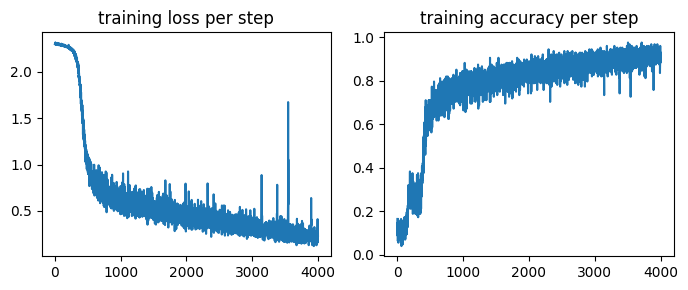

In [ ]:
model = CNN_fashionMNIST()
loss_function = t.nn.CrossEntropyLoss()
optimizer = t.optim.SGD(model.parameters(), lr=0.01)

loss_per_step, accuracy_per_step = train(subset_mnist_train_loader, model, loss_function, optimizer)
plt.figure(figsize=(7, 3))
p = plt.subplot(1, 2, 1)
p.plot(loss_per_step)
p.set_title("training loss per step")
q = plt.subplot(1, 2, 2)
q.plot(accuracy_per_step)
q.set_title("training accuracy per step")
plt.tight_layout()
plt.show()

In [ ]:
test_outputs = model(mnist_X_test_tensor)
_, test_prediction = t.max(test_outputs, 1)
test_correct = (test_prediction == mnist_y_test_tensor).sum().item()
test_accuracy = test_correct / mnist_y_test_tensor.size(0)
test_loss = loss_function(test_outputs, mnist_y_test_tensor).item()

print(test_loss)
print(test_accuracy)

# we could see that the performance of CNN (~0.78) is similar to than of MLP (~0.73) (~0.8?)
# note that our CNN in trained 500 epochs

0.7013275027275085
0.783


### Subtask 3.7: Test CNN (PyTorch) vs. our MLP on CIFAR-10

In [ ]:
# first, extract some subset of CIFAR-10 data
cifar_train_size = 1024
cifar_train_loader = t.utils.data.DataLoader(cifar_train_df, batch_size=cifar_train_size, shuffle=True)
cifar_train_iter = iter(cifar_train_loader)
cifar_X_tensor, cifar_y_tensor = next(cifar_train_iter)

subset_cifar_train_df = t.utils.data.Subset(cifar_train_df, range(1024))
subset_cifar_train_iter = t.utils.data.DataLoader(subset_cifar_train_df, batch_size=128, shuffle=True)

# Collapse the 1, 2, 3 dimensions of X_tensor into 1
cifar_X = cifar_X_tensor.numpy().reshape((cifar_train_size, -1))
cifar_y = cifar_y_tensor.numpy()
# now, use X, y for our MLP, use X_tensor, y_tensor for PyTorch CNN

cifar_test_size = 10000
cifar_test_loader = t.utils.data.DataLoader(cifar_test_df, batch_size=cifar_test_size, shuffle=True)
cifar_test_iter = iter(cifar_test_loader)
cifar_X_test_tensor, cifar_y_test_tensor = next(cifar_test_iter)

cifar_X_test = cifar_X_test_tensor.numpy().reshape((cifar_test_size, -1))
cifar_y_test = cifar_y_test_tensor.numpy()

In [ ]:
# MLP
model_mlp = MLP(ReLU, ReLU_derivative, hidden=2, units=[128, 128], initializer="xavier")
loss_mlp, _, train_accuracy_mlp = model_mlp.fit(cifar_X, cifar_y, batchsize=128, epochs=500)
_, accuracy_mlp = model_mlp.calculate_metric_given_X(cifar_X_test, cifar_y_test)
# we will use MLP with 1 layer here (128 units), since by our test it works better than the 2-layer [128, 128] units one
# this could be due to the extra representation power, making the deeper MLP harder to train (so it's underfitting)

In [ ]:
# CNN: need to build another class since the dimension of images are different
class CNN_CIFAR10(t.nn.Module):
    def __init__(self):
        super(CNN_CIFAR10, self).__init__()
        # input is N x 3 x 32 x 32
        self.conv1 = t.nn.Conv2d(3, 16, 5)
        # now dimension is N x 16 x (32 - 5 + 1) x (32 - 5 + 1) = N x 16 x 28 x 28; after 2x2 pooling it's N x 16 x 14 x 14
        self.conv2 = t.nn.Conv2d(16, 32, 3)
        # now dimension is N x 32 x (14 - 3 + 1) x (14 - 3 + 1) = N x 32 x 12 x 12; after 2x2 pooling it's N x 32 x 6 x 6
        self.fc1 = t.nn.Linear(32 * 6 * 6, 128)
        self.fc2 = t.nn.Linear(128, 128)
        self.fc3 = t.nn.Linear(128, 10)
        # as demanded, we let the number of units to be 128 in fully-connected layers

    def forward(self, X):
        X = F.relu(self.conv1(X))     # after convolution and applying ReLU activation, 8x24x24
        X = F.max_pool2d(X, (2, 2))   # after 2x2 pooling, N x 8 x 12 x 12
        X = F.relu(self.conv2(X))     # after convolution and applying ReLU activation, 16x10x10
        X = F.max_pool2d(X, (2, 2))   # after 2x2 pooling, N x 16 x 5 x 5
        # now, flatten X as we are going to use fully-connecter layers
        X = X.view(X.shape[0], -1)
        X = F.relu(self.fc1(X))       # after this layer, N x 128
        X = F.relu(self.fc2(X))       # still N x 128
        X = self.fc3(X)               # note that we didn't apply activation here in the last layer (unlike our implementation of MLP)
        # number of classes is 10
        return X

In [ ]:
model_cnn = CNN_CIFAR10()
loss_function_cnn = t.nn.CrossEntropyLoss()
optimizer_cnn = t.optim.SGD(model_cnn.parameters(), lr=0.01)        # note our lr in MLP and CNN are the same (0.01)

loss_cnn, train_accuracy_cnn = train(subset_cifar_train_iter, model_cnn, loss_function_cnn, optimizer_cnn, epochs=500)
test_outputs_cnn = model_cnn(cifar_X_test_tensor)
_, test_prediction_cnn = t.max(test_outputs_cnn, 1)
correct_cnn = (test_prediction_cnn == cifar_y_test_tensor).sum().item()
accuracy_cnn = correct_cnn / cifar_y_test_tensor.size(0)

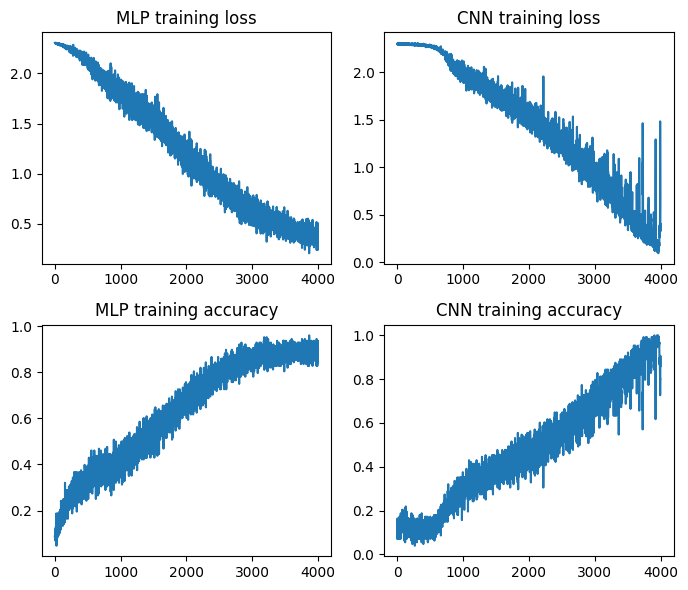

0.3346
0.3694


In [ ]:
plt.figure(figsize=(7, 6))
p = plt.subplot(2, 2, 1)
p.plot(loss_mlp)
p.set_title("MLP training loss")
q = plt.subplot(2, 2, 2)
q.plot(loss_cnn)
q.set_title("CNN training loss")
p = plt.subplot(2, 2, 3)
p.plot(train_accuracy_mlp)
p.set_title("MLP training accuracy")
q = plt.subplot(2, 2, 4)
q.plot(train_accuracy_cnn)
q.set_title("CNN training accuracy")
plt.tight_layout()
plt.show()

print(accuracy_mlp)
print(accuracy_cnn)

# seems like the low accuracy is not a problem of our code
# but 1. low representation power of our models (too shallow)
# and 2. small number of data that is used in training so the model cannot learn well

### Subtask 3.8: Test the performance of SGD optimizer and Adam optimizer on CNN (PyTorch)

In [ ]:
# SGD
momentums = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
train_losses_sgd = []
accuracies_sgd = []

for i, beta in enumerate(momentums):
    model_cnn = CNN_CIFAR10()
    loss_function_cnn = t.nn.CrossEntropyLoss()
    optimizer_cnn = t.optim.SGD(model_cnn.parameters(), lr=0.01, momentum=beta)

    loss_cnn, _ = train(subset_cifar_train_iter, model_cnn, loss_function_cnn, optimizer_cnn, epochs=500)
    train_losses_sgd.append(loss_cnn)
    test_outputs_cnn = model_cnn(cifar_X_test_tensor)
    _, test_prediction_cnn = t.max(test_outputs_cnn, 1)
    correct_cnn = (test_prediction_cnn == cifar_y_test_tensor).sum().item()
    accuracy_cnn = correct_cnn / cifar_y_test_tensor.size(0)
    accuracies_sgd.append(accuracy_cnn)

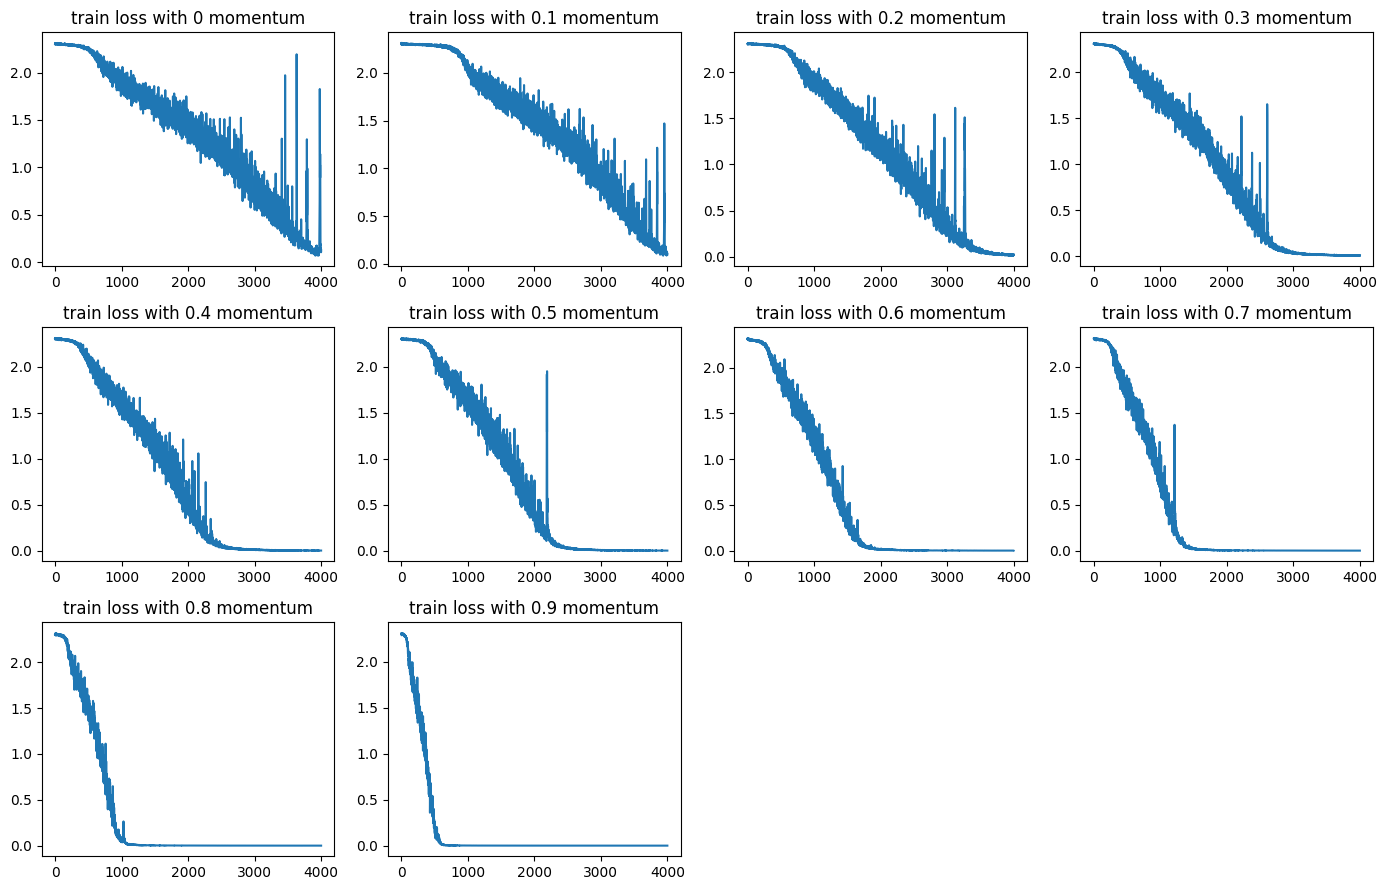

[0.3826, 0.3961, 0.3868, 0.3889, 0.374, 0.3722, 0.3728, 0.3888, 0.3801, 0.3852]


In [ ]:
plt.figure(figsize=(14, 9))
for i in range(len(accuracies_sgd)):
    p = plt.subplot(3, 4, i+1)
    p.plot(train_losses_sgd[i])
    p.set_title("train loss with {0} momentum".format(momentums[i]))
plt.tight_layout()
plt.show()

print(accuracies_sgd)

In [ ]:
# using ADAM now
momentums = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
train_losses_adam = []
accuracies_adam = []

for i, beta in enumerate(momentums):
    model_cnn = CNN_CIFAR10()
    loss_function_cnn = t.nn.CrossEntropyLoss()
    optimizer_cnn = t.optim.Adam(model_cnn.parameters(), lr=0.01, betas=(momentums[i], 0.999))

    loss_cnn, _ = train(subset_cifar_train_iter, model_cnn, loss_function_cnn, optimizer_cnn, epochs=500)
    train_losses_adam.append(loss_cnn)
    test_outputs_cnn = model_cnn(cifar_X_test_tensor)
    _, test_prediction_cnn = t.max(test_outputs_cnn, 1)
    correct_cnn = (test_prediction_cnn == cifar_y_test_tensor).sum().item()
    accuracy_cnn = correct_cnn / cifar_y_test_tensor.size(0)
    accuracies_adam.append(accuracy_cnn)

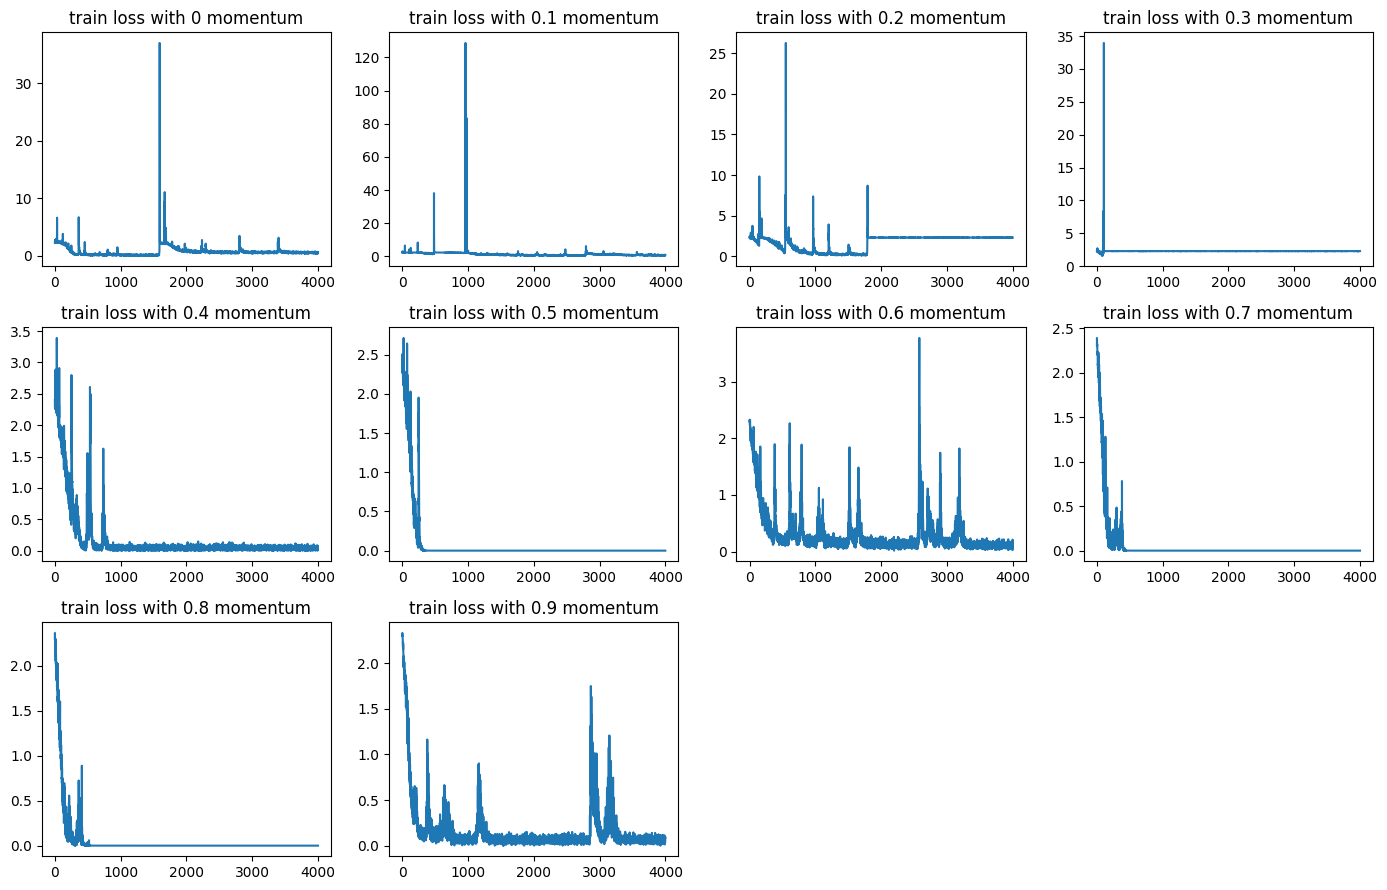

[0.2324, 0.1849, 0.1, 0.1, 0.2937, 0.3447, 0.2542, 0.3187, 0.3484, 0.2619]


In [ ]:
plt.figure(figsize=(14, 9))
for i in range(len(accuracies_adam)):
    p = plt.subplot(3, 4, i+1)
    p.plot(train_losses_adam[i])
    p.set_title("train loss with {0} momentum".format(momentums[i]))
plt.tight_layout()
plt.show()

print(accuracies_adam)
# the bad results could be due to a bad pairing of the beta1 and beta2:
# I set beta2 to be big (0.999) but when beta1 is small they don't cooperate well

### Subtask 3.9 (Bonus): Test the behavior and performance of pre-trained model (ResNet)